In [1]:
# Parameters
image_path1 = "human_picture\\000100.jpg"


In [2]:
import cv2
import ast
import dlib
import pandas as pd
import imutils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
import random
from scipy.optimize import linear_sum_assignment
from scipy.spatial import procrustes
from scipy.spatial.distance import euclidean

In [3]:
detector = dlib.get_frontal_face_detector()
shape_predictor = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(shape_predictor)

In [4]:
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def shape_to_np(shape, image_height, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        x = shape.part(i).x
        y = image_height - shape.part(i).y 
        coords[i] = (x, y)
    return coords

def extract_facial_landmarks(image_path, shape_predictor):
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=500)
    image_height = image.shape[0] 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    shapes = []
    for rect in rects:
        shape = predictor(gray, rect)
        shape = shape_to_np(shape, image_height)  
        shapes.append(shape)
    return image, shapes

"""
def extract_all_non_white_points(image_path, num_points=68):
    with Image.open(image_path) as img:
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = np.array(img)

        img = imutils.resize(img, width=500)
        pixels = np.array(img)

    white_threshold = 245
    non_white_pixels = np.where(np.any(pixels < white_threshold, axis=-1))
    non_white_point_coordinates = list(zip(non_white_pixels[1], non_white_pixels[0]))

    if len(non_white_point_coordinates) < num_points:
        raise ValueError("Not enough non-white points to sample the desired number of points.")
    sampled_points = random.sample(non_white_point_coordinates, num_points)

    return sampled_points
"""

'\ndef extract_all_non_white_points(image_path, num_points=68):\n    with Image.open(image_path) as img:\n        if img.mode != \'RGB\':\n            img = img.convert(\'RGB\')\n        img = np.array(img)\n\n        img = imutils.resize(img, width=500)\n        pixels = np.array(img)\n\n    white_threshold = 245\n    non_white_pixels = np.where(np.any(pixels < white_threshold, axis=-1))\n    non_white_point_coordinates = list(zip(non_white_pixels[1], non_white_pixels[0]))\n\n    if len(non_white_point_coordinates) < num_points:\n        raise ValueError("Not enough non-white points to sample the desired number of points.")\n    sampled_points = random.sample(non_white_point_coordinates, num_points)\n\n    return sampled_points\n'

In [5]:
#detector = dlib.get_frontal_face_detector()
#shape_predictor = 'shape_predictor_68_face_landmarks.dat'
#predictor = dlib.shape_predictor(shape_predictor)
image1, shapes1 = extract_facial_landmarks(image_path1, shape_predictor)

In [6]:
def transform_points(points, x_range, y_range):
    min_x, max_x = x_range
    min_y, max_y = y_range
    
    orig_min_x = min(points, key=lambda p: p[0])[0]
    orig_max_x = max(points, key=lambda p: p[0])[0]
    orig_min_y = min(points, key=lambda p: p[1])[1]
    orig_max_y = max(points, key=lambda p: p[1])[1]

    transformed_points = []
    for x, y in points:
        new_x = min_x + (x - orig_min_x) / (orig_max_x - orig_min_x) * (max_x - min_x)
        new_y = min_y + (y - orig_min_y) / (orig_max_y - orig_min_y) * (max_y - min_y)
        transformed_points.append((new_x, new_y))

    return transformed_points

In [7]:
def calculate_euclidean_distance(shapes1, shapes2):
    distances = []
    for point1 in shapes1:
        min_distance = min(np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) for point2 in shapes2)
        distances.append(min_distance)
    return np.mean(distances)

In [8]:
def calculate_similarity(shapes1, shapes2):
    cost_matrix = np.zeros((len(shapes1), len(shapes2)))
    for i, coord1 in enumerate(shapes1):
        for j, coord2 in enumerate(shapes2):
            cost_matrix[i, j] = np.linalg.norm(np.array(coord1) - np.array(coord2))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    total_distance = cost_matrix[row_ind, col_ind].sum()
    max_distance = np.max(cost_matrix) * len(shapes1)
    similarity = 100 - (total_distance / max_distance * 100)

    return similarity

In [9]:
def calculate_min_max_avg_distance(shapes1, shapes2):
    all_distances = []
    for point1 in shapes1:
        distances = [np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) for point2 in shapes2]
        all_distances.append(min(distances))

    return np.min(all_distances), np.max(all_distances), np.mean(all_distances)

In [10]:
def calculate_density(shapes1, shapes2, radius=250):
    density_list = []
    for point1 in shapes1:
        count = sum(np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) < radius for point2 in shapes2)
        density_list.append(count)
    return density_list

In [11]:
def calculate_knn_distance(shapes1, shapes2, k=1):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(shapes2)

    distances, _ = neigh.kneighbors(shapes1)

    return np.mean(distances)

In [12]:
def EMD(shapes1, shapes2):
    cost_matrix = np.zeros((len(shapes1), len(shapes2)))
    for i, coord1 in enumerate(shapes1):
        for j, coord2 in enumerate(shapes2):
            cost_matrix[i, j] = np.linalg.norm(np.array(coord1) - np.array(coord2))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_distance = cost_matrix[row_ind, col_ind].sum()
    max_distance = np.max(cost_matrix) * len(shapes1)
    similarity = 100 - (total_distance / max_distance * 100)

    return similarity

In [13]:
def calculate_jaccard_similarity(shapes1, shapes2, threshold):
    similar_pairs = 0
    for point1 in shapes1:
        if any(np.linalg.norm(np.array(point1) - np.array(point2)) < threshold for point2 in shapes2):
            similar_pairs += 1
    for point2 in shapes2:
        if any(np.linalg.norm(np.array(point2) - np.array(point1)) < threshold for point1 in shapes1):
            similar_pairs += 1
    similar_pairs = similar_pairs / 2
    union_size = len(shapes1) + len(shapes2) - similar_pairs
    jaccard_similarity = (similar_pairs / union_size) * 100

    return jaccard_similarity

In [14]:
def calculate_procrustes_similarity(shapes1, shapes2):
    mtx1 = np.array(shapes1)
    mtx2 = np.array(shapes2)
    mtx1_transformed, mtx2_transformed, disparity = procrustes(mtx1, mtx2)
    similarity_score = 1 / (1 + disparity)
    similarity_score_normalized = similarity_score * 100
    similarity_score_normalized = max(min(similarity_score_normalized, 100), 0)
    
    return similarity_score_normalized
    

In [15]:
def perform_comparisons(shapes1, shapes2, weights, max_values):
    euclidean_distance = calculate_euclidean_distance(shapes1, shapes2)
    min_distance, max_distance, avg_distance = calculate_min_max_avg_distance(shapes1, shapes2)
    density = calculate_density(shapes1, shapes2)
    knn_distance = calculate_knn_distance(shapes1, shapes2, k=50)
    KuhnMunkres = calculate_similarity(shapes1, shapes2)
    emd = EMD(shapes1,shapes2)
    jaccard = calculate_jaccard_similarity(shapes1, shapes2,threshold = 42.5)
    procrustes = calculate_procrustes_similarity(shapes1, shapes2)
    
    euclidean_score = max(0, min(100, (max_values['euclidean'] - euclidean_distance) / max_values['euclidean'] * 100))
    min_max_avg_score = max(0, min(100, (max_values['min_max_avg'] - avg_distance) / max_values['min_max_avg'] * 100))
    density_score = max(0, min(100, np.mean(density) / max_values['density'] * 100))
    knn_score = max(0, min(100, (max_values['knn'] - knn_distance) / max_values['knn'] * 100))


    weighted_average_score = (
        weights["euclidean"] * euclidean_score +
        weights["density"] * density_score +
        weights["knn"] * knn_score + 
        weights["EMD"] * emd + 
        weights["jaccard"] * jaccard +
        weights["procrustes"] * procrustes 
    )


    return weighted_average_score

In [16]:


max_values = {
    "euclidean": np.sqrt((400 - 150) ** 2 + (300 - 50) ** 2),
    "min_max_avg": np.sqrt((400 - 150) ** 2 + (300 - 50) ** 2),
    "density": 68,  
    "knn": 1700, 
    
}

In [17]:
def process_folder(folder_path, shapes1, weights, max_values):
    scores = {}
    pointsdata = pd.read_csv("random_points.csv")
    df = pd.DataFrame(pointsdata)
    #image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
    for num in range(0,110):
        shapes2 = df.iloc[num].to_list()
        image_file = shapes2[0]
        shapes2.remove(image_file)
        shapes2 = [ast.literal_eval(point) for point in shapes2]
        x_range = (150, 400)
        y_range = (50, 300)
        shapes1_new = transform_points(shapes1[0], x_range, y_range)
        shapes2_new = transform_points(shapes2, x_range, y_range)
        score = perform_comparisons(shapes1_new, shapes2_new, weights, max_values)
        scores[image_file] = score
        #print(f"Score for {image_file}: {score:.2f}") 
    return scores

folder_path = 'images'  
scores = process_folder(folder_path, shapes1, weights, max_values)
highest_score_image = max(scores, key=scores.get)
highest_score_image_path = os.path.join(folder_path, highest_score_image)

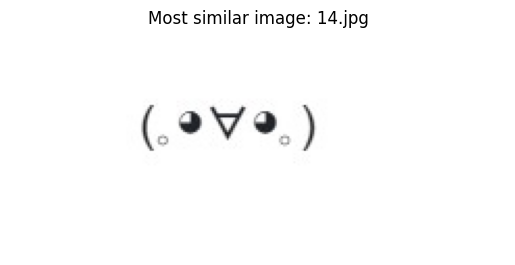

In [18]:
img = Image.open(highest_score_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Most similar image: {highest_score_image}")
plt.show()

In [19]:
import pandas as pd

# 讀取 CSV 檔案 #要改
data = pd.read_csv(file_path)

# 尋找 'match' 欄位中第一個空白的位置
match_column = 'match'
first_empty_index = data[data[match_column].isna()].index.min()

if pd.isna(first_empty_index):
    # 如果沒有空白位置，則在末尾添加一行
    new_row = {match_column: highest_score_image, 'count': 0}  # 假設 'count' 應該是 0
    data = data.append(new_row, ignore_index=True)
else:
    # 在第一個空白位置插入圖片檔案名稱
    data.at[first_empty_index, match_column] = highest_score_image

# 儲存修改後的 CSV 檔案
data.to_csv(file_path, index=False)
import pandas as pd

# 讀取 CSV 檔案
file_path = 'Kaomoji.csv'  # 替換成您的 CSV 檔案路徑
kaomoji_data = pd.read_csv(file_path)

# 找到第一列中名字與 highest_score_image 相同的那一行
matching_row = kaomoji_data[kaomoji_data.iloc[:, 0] == highest_score_image]

# 如果找到相應的行，則顯示出來
if not matching_row.empty:
    print(matching_row)
else:
    print("No matching row found.")

# 提取第二列、第三列和第四列的值
eye_kao = matching_row.iloc[0]['eyes']  # Eye Size
emo_kao = matching_row.iloc[0]['emotion']  # Highest Emotion
mouth_kao = matching_row.iloc[0]['mouth']  # Mouth State

# 印出這些值以確認
print(f"Eye Size: {eye_kao}")
print(f"Emotion: {emo_kao}")
print(f"Mouth State: {mouth_kao}")
import pandas as pd

# 讀取 Human.csv 檔案
human_file_path = 'Human.csv'  # 替換為您的 CSV 檔案路徑
human_data = pd.read_csv(human_file_path)

# 找到名字與 image_path1 相同的那列
matching_human_row = human_data[human_data.iloc[:, 0] == image_path1]

# 如果找到相應的列，則提取第二列、第三列和第四列的值
if not matching_human_row.empty:
    # 提取第二列、第三列和第四列的值
    eye_hum = matching_human_row.iloc[0]['Eye Size']  # Eye Size
    emo_hum = matching_human_row.iloc[0]['Highest Emotion']  # Highest Emotion
    mouth_hum = matching_human_row.iloc[0]['Mouth State']  # Mouth State
else:
    eye_hum = emo_hum = mouth_hum = None  # 如果沒有匹配的列，則設為 None

# 您可以根據需要處理這些變數或印出它們
print(eye_hum, emo_hum, mouth_hum)
import pandas as pd

# 假定的匹配檔案名稱和 CSV 檔案路徑   #要改

match_data = pd.read_csv(match_file_path)

# 初始化 count
count = 0

    # 如果值相同，則 count 加一
if eye_kao == eye_hum:
    first_empty_index = match_data[match_data['eye'].isna()].index.min()
    match_data.at[first_empty_index, 'eye'] = 1
else:
    first_empty_index = match_data[match_data['eye'].isna()].index.min()
    match_data.at[first_empty_index, 'eye'] = 0

if emo_kao == emo_hum:
    first_empty_index = match_data[match_data['emo'].isna()].index.min()
    match_data.at[first_empty_index, 'emo'] = 1
else:
    first_empty_index = match_data[match_data['emo'].isna()].index.min()
    match_data.at[first_empty_index, 'emo'] = 0

if mouth_kao == mouth_hum:
    first_empty_index = match_data[match_data['mouth'].isna()].index.min()
    match_data.at[first_empty_index, 'mouth'] = 1
else:
    first_empty_index = match_data[match_data['mouth'].isna()].index.min()
    match_data.at[first_empty_index, 'mouth'] = 0


# 尋找 match(68points).csv 中第一個空白的 'count' 欄位


# 儲存更改
match_data.to_csv(match_file_path, index=False)


        id emotion eyes mouth  eyebrow     tear    sweat     nose blush
13  14.jpg   happy  big  open  haven't  haven't  haven't  haven't  have
Eye Size: big
Emotion: happy
Mouth State: open
small happy close
